In [1]:
import numpy as np
import xarray as xr
from u import *
from scipy.io import savemat
import xesmf as xe

In [2]:
Base = Path('/net/d07/data/rlan/from_hex/inventory')
home = Path('/home/rlan/inventory')

In [3]:
def read(path):
    ds = xr.open_dataset(path)
    return ds

In [4]:
inventory = ['GFED','QFED','GFAS','FINN','FEER','SAGE']
inventory_full_name = ['GFEDv4s','QFEDv2p5r1','GFASv1p2','FINNv1p5','FEERv1_G1p2','GFED4_SAGEIGP_gen.025x025']

# Emission factor (g/kg)
* BC: 0.42
* OC: 4.9

# Dry matter unit - kg/m2/s


# Create regridder for GFED and SAGE

In [5]:
ds_in = read(Base/'GFED'/'2003'/'GFEDv4s_2003_01_BC.nc')
nested_grid_with_bounds = {'lon': np.arange(65.05, 100.1, 0.1),
                           'lat': np.arange(5.05, 40.1, 0.1),
                           'lon_b': np.arange(65.05-0.1/2, 100.1+0.1/2, 0.1),
                           'lat_b': np.arange(5.05-0.1/2, 40.1+0.1/2, 0.1),
                          }

global_grid_with_bounds = {'lon': ds_in['lon'].values,
                           'lat': ds_in['lat'].values,
                           'lon_b': np.arange(-179.875-0.25/2, 180+0.25/2, 0.25),
                           'lat_b': np.arange(-89.875-0.25/2, 90+0.25/2, 0.25), 
                          }

regridder_conserve = xe.Regridder(global_grid_with_bounds, nested_grid_with_bounds, method='conservative')

In [20]:
global_grid_with_bounds['lat'].shape

(720,)

In [30]:
nested_grid_with_bounds['lat'].shape

(351,)

# Load area (m2)

In [8]:
ds = xr.open_dataset("/home/rlan/inventory/countrymask_0.1x0.1.nc")
area = ds.cell_area.sel(lon=slice(65.05,100.1),lat=slice(5.05,40.1))
area.shape

(351, 351)

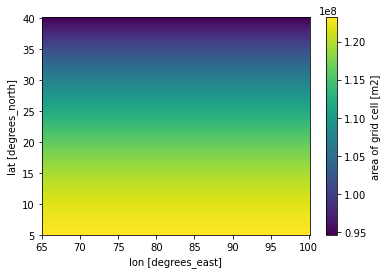

In [9]:
area.plot()

In [13]:
ds.close()

# Load India mask

In [11]:
ds = xr.open_dataset("/home/rlan/inventory/countrymask_0.1x0.1.nc")
mask = (ds['CountryID'].isel(time=0) == 356).sel(lon=slice(65.05,100.1),lat=slice(5.05,40.1))
mask.shape

(351, 351)

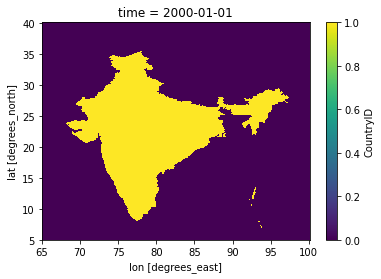

In [12]:
mask.plot()

# SAGE GFED (need regridding)

In [77]:
factor = 140**2/351**2
inv,inv_full  = inventory[-1], inventory_full_name[-1]
interannual_PM = []
for year in range(2003,2020):
    print(inv, year)
    annual_PM = []
    for month in tqdm(range(1,13)):
        ds = read(Base/inv/year/f'{inv_full}.{year}{month:02d}.nc')
        agri = regridder_conserve(ds['DM_AGRI']) # (BC + 2OC) g/m2/s
        ds = read(Base/inv/year/f'GFED4_SAGEIGP_dailyfrac_gen.025x025.{year}{month:02d}.nc')
        frac = regridder_conserve(ds['GFED_FRACDAY']) # unitless
        if month in [10, 11]:
            PM = agri * frac * 0.0436
        else:
            PM = agri * frac
        annual_PM.append(PM)
    annual_PM = xr.concat(annual_PM, dim='time')
    annual_PM.to_netcdf(home/'nc_files_351'/inv/f'SAGEIGP_{year}.nc')
    interannual_PM.append(annual_PM.mean(dim='time'))
interannual_PM = xr.concat(interannual_PM, dim='time')
interannual_PM.to_netcdf(home/'nc_files_351'/inv/'SAGEIGP_23yr.nc')

SAGE 2003


100%|██████████| 12/12 [00:10<00:00,  1.16it/s]


SAGE 2004


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]


SAGE 2005


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


SAGE 2006


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


SAGE 2007


100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


SAGE 2008


100%|██████████| 12/12 [00:10<00:00,  1.16it/s]


SAGE 2009


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


SAGE 2010


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


SAGE 2011


100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


SAGE 2012


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


SAGE 2013


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


SAGE 2014


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


SAGE 2015


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


SAGE 2016


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


SAGE 2017


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]


SAGE 2018


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


SAGE 2019


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]


In [78]:
inv,inv_full  = inventory[-1], inventory_full_name[-1]
interannual_PM_rice = []
for year in range(2003,2020):
    print(inv, year)
    annual_PM = []
    for month in tqdm(range(10,12)):
        ds = read(Base/inv/year/f'{inv_full}.{year}{month:02d}.nc')
        agri = regridder_conserve(ds['DM_AGRI']) # (BC + 2OC) g/m2/s
        ds = read(Base/inv/year/f'GFED4_SAGEIGP_dailyfrac_gen.025x025.{year}{month:02d}.nc')
        frac = regridder_conserve(ds['GFED_FRACDAY']) # unitless
        PM = agri * frac * 0.0436
        annual_PM.append(PM)
    annual_PM = xr.concat(annual_PM, dim='time')
    interannual_PM_rice.append(annual_PM.mean(dim='time'))
interannual_PM_rice = xr.concat(interannual_PM_rice, dim='time')
interannual_PM_rice.to_netcdf(home/'nc_files_351'/inv/'SAGEIGP_23yr_rice.nc')

SAGE 2003


100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


SAGE 2004


100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


SAGE 2005


100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


SAGE 2006


100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


SAGE 2007


100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


SAGE 2008


100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


SAGE 2009


100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


SAGE 2010


100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


SAGE 2011


100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


SAGE 2012


100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


SAGE 2013


100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


SAGE 2014


100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


SAGE 2015


100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


SAGE 2016


100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


SAGE 2017


100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


SAGE 2018


100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


SAGE 2019


100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


# GFED (need regridding)

In [80]:
inv,inv_full  = inventory[0], inventory_full_name[0]
interannual_PM = []
for year in range(2003,2020):
    print(inv, year)
    annual_PM = []
    for month in tqdm(range(1,13)):
        ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_BC.nc')
        BC = regridder_conserve(ds['BC']) * (0.42) # (BC) g/m2/s
        ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_OC.nc')
        OC = regridder_conserve(ds['OC']) * (4.9) # (OC) g/m2/s
        PM = BC + 2.1 * OC # g/m2/s
        annual_PM.append(PM)
    annual_PM = xr.concat(annual_PM, dim='time')
    annual_PM.to_netcdf(home/'nc_files_351'/inv/f'{inv_full}_{year}.nc')
    interannual_PM.append(annual_PM.mean(dim='time'))
interannual_PM = xr.concat(interannual_PM, dim='time')
interannual_PM.to_netcdf(home/'nc_files_351'/inv/f'{inv_full}_23yr.nc')

GFED 2003


100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


GFED 2004


100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


GFED 2005


100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


GFED 2006


100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


GFED 2007


100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


GFED 2008


100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


GFED 2009


100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


GFED 2010


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


GFED 2011


100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


GFED 2012


100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


GFED 2013


100%|██████████| 12/12 [00:15<00:00,  1.27s/it]


GFED 2014


100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


GFED 2015


100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


GFED 2016


100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


GFED 2017


100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


GFED 2018


100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


GFED 2019


100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


In [79]:
inv,inv_full  = inventory[0], inventory_full_name[0]
interannual_PM_rice = []
for year in range(2003,2020):
    print(inv, year)
    annual_PM = []
    for month in tqdm(range(10,12)):
        ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_BC.nc')
        BC = regridder_conserve(ds['BC']) * (0.42) # (BC) g/m2/s
        ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_OC.nc')
        OC = regridder_conserve(ds['OC']) * (4.9) # (OC) g/m2/s
        PM = BC + 2.1 * OC # g/m2/s
        annual_PM.append(PM)
    annual_PM = xr.concat(annual_PM, dim='time')
    interannual_PM_rice.append(annual_PM.mean(dim='time'))
interannual_PM_rice = xr.concat(interannual_PM_rice, dim='time')
interannual_PM_rice.to_netcdf(home/'nc_files_351'/inv/f'{inv_full}_23yr_rice.nc')

GFED 2003


100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


GFED 2004


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


GFED 2005


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


GFED 2006


100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


GFED 2007


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


GFED 2008


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


GFED 2009


100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


GFED 2010


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


GFED 2011


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


GFED 2012


100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


GFED 2013


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


GFED 2014


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


GFED 2015


100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


GFED 2016


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


GFED 2017


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


GFED 2018


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


GFED 2019


100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


# QFED, GFAS, FINN, FEER

In [46]:
for inv,inv_full in zip(inventory[1:-1], inventory_full_name[1:-1]):
    interannual_PM = []
    for year in range(2003,2020):
        print(inv, year)
        annual_PM = []
        for month in tqdm(range(1,13)):
            ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_BC.nc')
            BC = ds['BC'].sel(lon=slice(65.05,100.1),lat=slice(5,40.1)) * (0.42) # (BC) g/m2/s
            ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_OC.nc')
            OC = ds['OC'].sel(lon=slice(65.05,100.1),lat=slice(5,40.1)) * (4.9) # (OC) g/m2/s
            PM = BC + 2.1 * OC # g/m2/s
            annual_PM.append(PM)
        annual_PM = xr.concat(annual_PM, dim='time')
        annual_PM.to_netcdf(home/'nc_files_351'/inv/f'{inv_full}_{year}.nc')
        interannual_PM.append(annual_PM.mean(dim='time'))
    interannual_PM = xr.concat(interannual_PM, dim='time')
    interannual_PM.to_netcdf(home/'nc_files_351'/inv/f'{inv_full}_23yr.nc')

QFED 2003


100%|██████████| 12/12 [00:03<00:00,  3.10it/s]


QFED 2004


100%|██████████| 12/12 [00:03<00:00,  3.27it/s]


QFED 2005


100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


QFED 2006


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


QFED 2007


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


QFED 2008


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


QFED 2009


100%|██████████| 12/12 [00:03<00:00,  3.26it/s]


QFED 2010


100%|██████████| 12/12 [00:03<00:00,  3.30it/s]


QFED 2011


100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


QFED 2012


100%|██████████| 12/12 [00:04<00:00,  2.99it/s]


QFED 2013


100%|██████████| 12/12 [00:03<00:00,  3.28it/s]


QFED 2014


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


QFED 2015


100%|██████████| 12/12 [00:03<00:00,  3.25it/s]


QFED 2016


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


QFED 2017


100%|██████████| 12/12 [00:03<00:00,  3.58it/s]


QFED 2018


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


QFED 2019


100%|██████████| 12/12 [00:03<00:00,  3.71it/s]


GFAS 2003


100%|██████████| 12/12 [00:03<00:00,  3.14it/s]


GFAS 2004


100%|██████████| 12/12 [00:03<00:00,  3.14it/s]


GFAS 2005


100%|██████████| 12/12 [00:03<00:00,  3.26it/s]


GFAS 2006


100%|██████████| 12/12 [00:03<00:00,  3.47it/s]


GFAS 2007


100%|██████████| 12/12 [00:03<00:00,  3.80it/s]


GFAS 2008


100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


GFAS 2009


100%|██████████| 12/12 [00:02<00:00,  4.13it/s]


GFAS 2010


100%|██████████| 12/12 [00:03<00:00,  3.96it/s]


GFAS 2011


100%|██████████| 12/12 [00:03<00:00,  3.85it/s]


GFAS 2012


100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


GFAS 2013


100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


GFAS 2014


100%|██████████| 12/12 [00:03<00:00,  3.86it/s]


GFAS 2015


100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


GFAS 2016


100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


GFAS 2017


100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


GFAS 2018


100%|██████████| 12/12 [00:03<00:00,  3.77it/s]


GFAS 2019


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


FINN 2003


100%|██████████| 12/12 [00:03<00:00,  3.10it/s]


FINN 2004


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


FINN 2005


100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


FINN 2006


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


FINN 2007


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


FINN 2008


100%|██████████| 12/12 [00:03<00:00,  3.13it/s]


FINN 2009


100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


FINN 2010


100%|██████████| 12/12 [00:03<00:00,  3.28it/s]


FINN 2011


100%|██████████| 12/12 [00:03<00:00,  3.15it/s]


FINN 2012


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


FINN 2013


100%|██████████| 12/12 [00:03<00:00,  3.29it/s]


FINN 2014


100%|██████████| 12/12 [00:03<00:00,  3.31it/s]


FINN 2015


100%|██████████| 12/12 [00:03<00:00,  3.24it/s]


FINN 2016


100%|██████████| 12/12 [00:03<00:00,  3.28it/s]


FINN 2017


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


FINN 2018


100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


FINN 2019


100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


FEER 2003


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


FEER 2004


100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


FEER 2005


100%|██████████| 12/12 [00:03<00:00,  3.48it/s]


FEER 2006


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


FEER 2007


100%|██████████| 12/12 [00:03<00:00,  3.20it/s]


FEER 2008


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


FEER 2009


100%|██████████| 12/12 [00:03<00:00,  3.19it/s]


FEER 2010


100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


FEER 2011


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


FEER 2012


100%|██████████| 12/12 [00:03<00:00,  3.14it/s]


FEER 2013


100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


FEER 2014


100%|██████████| 12/12 [00:03<00:00,  3.10it/s]


FEER 2015


100%|██████████| 12/12 [00:03<00:00,  3.27it/s]


FEER 2016


100%|██████████| 12/12 [00:03<00:00,  3.20it/s]


FEER 2017


100%|██████████| 12/12 [00:03<00:00,  3.29it/s]


FEER 2018


100%|██████████| 12/12 [00:03<00:00,  3.29it/s]


FEER 2019


100%|██████████| 12/12 [00:03<00:00,  3.55it/s]


In [47]:
for inv,inv_full in zip(inventory[1:-1], inventory_full_name[1:-1]):
    interannual_PM_rice = []
    for year in range(2003,2020):
        print(inv, year)
        annual_PM = []
        for month in tqdm(range(10,12)):
            ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_BC.nc')
            BC = ds['BC'].sel(lon=slice(65.05,100.1),lat=slice(5,40.1)) * (0.42) # (BC) g/m2/s
            ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_OC.nc')
            OC = ds['OC'].sel(lon=slice(65.05,100.1),lat=slice(5,40.1)) * (4.9) # (OC) g/m2/s
            PM = BC + 2.1 * OC # g/m2/s
            annual_PM.append(PM)
        annual_PM = xr.concat(annual_PM, dim='time')
        interannual_PM_rice.append(annual_PM.mean(dim='time'))
    interannual_PM_rice = xr.concat(interannual_PM_rice, dim='time')
    interannual_PM_rice.to_netcdf(home/'nc_files_351'/inv/f'{inv_full}_23yr_rice.nc')

QFED 2003


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


QFED 2004


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


QFED 2005


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


QFED 2006


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


QFED 2007


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


QFED 2008


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


QFED 2009


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


QFED 2010


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


QFED 2011


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


QFED 2012


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


QFED 2013


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


QFED 2014


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


QFED 2015


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


QFED 2016


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


QFED 2017


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


QFED 2018


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


QFED 2019


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


GFAS 2003


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


GFAS 2004


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


GFAS 2005


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


GFAS 2006


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


GFAS 2007


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


GFAS 2008


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


GFAS 2009


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


GFAS 2010


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


GFAS 2011


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


GFAS 2012


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


GFAS 2013


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


GFAS 2014


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


GFAS 2015


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


GFAS 2016


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


GFAS 2017


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


GFAS 2018


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


GFAS 2019


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


FINN 2003


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


FINN 2004


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


FINN 2005


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


FINN 2006


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


FINN 2007


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


FINN 2008


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


FINN 2009


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


FINN 2010


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


FINN 2011


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


FINN 2012


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


FINN 2013


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


FINN 2014


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


FINN 2015


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


FINN 2016


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


FINN 2017


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


FINN 2018


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


FINN 2019


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


FEER 2003


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


FEER 2004


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


FEER 2005


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


FEER 2006


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


FEER 2007


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


FEER 2008


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


FEER 2009


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


FEER 2010


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


FEER 2011


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


FEER 2012


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


FEER 2013


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


FEER 2014


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


FEER 2015


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


FEER 2016


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


FEER 2017


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


FEER 2018


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


FEER 2019


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


In [48]:
for inv,inv_full in zip(inventory[1:-1], inventory_full_name[1:-1]):
    interannual_PM_rice = []
    for year in range(2003,2020):
        print(inv, year)
        annual_PM = []
        for month in tqdm(range(10,11)):
            ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_BC.nc')
            BC = ds['BC'].sel(lon=slice(65.05,100.1),lat=slice(5,40.1)) * (0.42) # (BC) g/m2/s
            ds = read(Base/inv/year/f'{inv_full}_{year}_{month:02d}_OC.nc')
            OC = ds['OC'].sel(lon=slice(65.05,100.1),lat=slice(5,40.1)) * (4.9) # (OC) g/m2/s
            PM = BC + 2.1 * OC # g/m2/s
            annual_PM.append(PM)
        annual_PM = xr.concat(annual_PM, dim='time')
        interannual_PM_rice.append(annual_PM.mean(dim='time'))
    interannual_PM_rice = xr.concat(interannual_PM_rice, dim='time')
    interannual_PM_rice.to_netcdf(home/'nc_files_351'/inv/f'{inv_full}_23yr_oct.nc')

QFED 2003


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


QFED 2004


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


QFED 2005


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


QFED 2006


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


QFED 2007


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


QFED 2008


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


QFED 2009


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


QFED 2010


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


QFED 2011


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


QFED 2012


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


QFED 2013


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


QFED 2014


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


QFED 2015


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


QFED 2016


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


QFED 2017


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


QFED 2018


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


QFED 2019


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


GFAS 2003


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


GFAS 2004


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


GFAS 2005


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


GFAS 2006


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


GFAS 2007


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


GFAS 2008


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


GFAS 2009


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


GFAS 2010


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


GFAS 2011


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


GFAS 2012


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


GFAS 2013


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


GFAS 2014


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


GFAS 2015


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


GFAS 2016


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


GFAS 2017


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


GFAS 2018


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


GFAS 2019


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


FINN 2003


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


FINN 2004


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


FINN 2005


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


FINN 2006


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


FINN 2007


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


FINN 2008


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


FINN 2009


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


FINN 2010


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


FINN 2011


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


FINN 2012


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


FINN 2013


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


FINN 2014


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


FINN 2015


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


FINN 2016


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


FINN 2017


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


FINN 2018


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


FINN 2019


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


FEER 2003


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


FEER 2004


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


FEER 2005


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


FEER 2006


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


FEER 2007


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


FEER 2008


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


FEER 2009


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


FEER 2010


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


FEER 2011


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


FEER 2012


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


FEER 2013


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


FEER 2014


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


FEER 2015


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


FEER 2016


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


FEER 2017


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


FEER 2018


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


FEER 2019


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


# Apply India mask and calculate India-wide emissions

In [59]:
home/'nc_files_351'/inv/f'{inv_full}_23yr.nc'

'/home/rlan/inventory/nc_files_351/QFED/QFEDv2p5r1_23yr.nc'

In [60]:
seconds = 24 * 60 * 60 # second to day
days = 365
years = 17
inventory = ['GFED','QFED','GFAS','FINN','FEER','SAGE']
inventory_full = ['GFEDv4s','QFEDv2p5r1','GFASv1p2','FINNv1p5','FEERv1_G1p2','SAGEIGP']
t_PM_all = []
t_PM_rice = []
s_PM_all = []
s_PM_rice = []

for inv,inv_full in zip(inventory, inventory_full):
    ds = read(home/'nc_files_351'/inv/f'{inv_full}_23yr.nc')
    ds = ds['__xarray_dataarray_variable__']
    ds = ds.sel(lon=slice(65.05,100.1),lat=slice(5,40.1)) 
    area['lon'] = ds.lon
    area['lat'] = ds.lat
    mask['lon'] = ds.lon
    mask['lat'] = ds.lat
    PM_all_time = xr.dot(ds, (area * mask )).values * seconds * days * years #g
    PM_all_space = (ds * (area * mask ) * seconds).mean(dim='time') * days * years
    s_PM_all.append(PM_all_space)
    t_PM_all.append(PM_all_time)
    
    ds = read(home/'nc_files_351'/inv/f'{inv_full}_23yr_rice.nc')
    ds = ds['__xarray_dataarray_variable__']
    ds = ds.sel(lon=slice(65.05,100.1),lat=slice(5,40.1)) 
    PM_rice_time = xr.dot(ds, (area * mask )).values * seconds * days * years #g
    PM_rice_space = (ds * (area * mask ) * seconds).mean(dim='time') * days * years
    s_PM_rice.append(PM_rice_space)
    t_PM_rice.append(PM_rice_time)
    
t_PM_all = np.array(t_PM_all)
t_PM_rice = np.array(t_PM_rice)
s_PM_all = np.array(s_PM_all)
s_PM_rice = np.array(s_PM_rice)

savemat(home/'mat_files'/'inventory_estimates.mat', mdict={'t_all': t_PM_all, 
                                                           't_rice': t_PM_rice,
                                                           's_all': s_PM_all,
                                                           's_rice': s_PM_rice})    

In [72]:
for year in range(2003,2020):
    file = Path(home/'nc_files_351'/'GFED'/f'GFEDv4s_{year}.nc')
    ds = read(file)
    ds = ds['__xarray_dataarray_variable__']
    BCOC = np.array(ds)
    savemat(home/'mat_files'/f'GFED_{year}.mat', mdict={'BCOC': BCOC})  


In [70]:
BCOC.shape

(365, 351, 351)